In [59]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [104]:
home_path_results = "/home/francisco/Documents/Practica/Time-Series-Library-1/results/"

In [105]:
datasets_path = "/home/francisco/Documents/Practica/Time-Series-Library-1/dataset/pr/"

In [106]:
coffe_df  = pd.read_csv(datasets_path+ 'Coffee_500Exog.csv')
coffe_results_df=  pd.read_csv(datasets_path+ 'Coffee_500Exog_results.csv')
sugar_df  = pd.read_csv(datasets_path+ 'Sugar_500Exog.csv')
sugar_results_df =  pd.read_csv(datasets_path+ 'Sugar_500Exog_results.csv')


In [107]:
coffe_df.head()

,date,id,value,Exog_1,Exog_2,Exog_3,Exog_4,Exog_5,Exog_6,Exog_7,...,Exog_491,Exog_492,Exog_493,Exog_494,Exog_495,Exog_496,Exog_497,Exog_498,Exog_499,Exog_500
0,2000-01-03,Coffee,114.15,0.85,4350,289.7,5.15,9699.0,1120.0,147.5,...,0.0,0.0,24.6,24.6,24.60,0.00,0.0,0.0,0.0,0.0
1,2000-01-10,Coffee,114.15,0.85,4350,286.0,5.20,9699.0,1120.0,147.5,...,0.0,0.0,28.1,23.6,25.85,2.76,0.0,0.0,0.0,0.0
2,2000-01-17,Coffee,112.55,0.86,4350,313.0,5.15,9699.0,1120.0,147.5,...,0.0,0.0,30.2,27.2,28.70,4.75,0.0,0.0,0.0,0.0
3,2000-01-24,Coffee,111.20,0.87,4350,313.6,5.26,9699.0,1120.0,147.5,...,0.0,0.0,31.9,24.1,28.00,5.33,0.0,0.0,0.0,0.0
4,2000-01-31,Coffee,114.70,0.83,4350,307.3,5.33,9699.0,1120.0,147.5,...,0.0,0.0,29.2,23.4,26.30,9.23,0.0,0.0,0.0,0.0


In [108]:
sugar_df.head()

,date,id,value,Exog_1,Exog_2,Exog_3,Exog_4,Exog_5,Exog_6,Exog_7,...,Exog_491,Exog_492,Exog_493,Exog_494,Exog_495,Exog_496,Exog_497,Exog_498,Exog_499,Exog_500
0,2000-01-03,Sugar,5.84,0.85,414.0,289.7,5.15,622.5,9699.0,96530,...,20.9,0.0,31.3,20.1,25.70,0.00,33.1,25.1,29.10,0.0
1,2000-01-10,Sugar,5.84,0.85,414.0,286.0,5.20,622.5,9699.0,96530,...,22.0,0.0,34.1,23.6,28.85,0.10,34.1,25.1,29.60,0.0
2,2000-01-17,Sugar,5.45,0.86,414.0,313.0,5.15,622.5,9699.0,96530,...,22.8,0.0,32.7,23.9,28.30,5.83,32.2,24.1,28.15,0.0
3,2000-01-24,Sugar,5.43,0.87,414.0,313.6,5.26,622.5,9699.0,96530,...,24.5,0.0,32.2,20.2,26.20,0.00,34.1,23.1,28.60,0.0
4,2000-01-31,Sugar,5.47,0.83,414.0,307.3,5.33,622.5,9699.0,96530,...,22.1,0.0,28.1,15.2,21.65,0.00,30.4,22.1,26.25,0.0


In [128]:
results_path = '/home/francisco/Documents/Practica/Time-Series-Library-1/results/long_term_forecast_coffee_TimesNet_custom_Coffee_500Exog.csv_bs128_lrtypeC_ftS_sl52_ll26_pl52_dm32_nh8_el3_dl2_df64_fc3_ebfixed_dtTrue_Exp_0/'

In [129]:
pred = np.load(results_path+'/pred.npy')
true = np.load(results_path+'/true.npy')

In [141]:
preds = np.squeeze(pred)
trues = np.squeeze(true)

In [143]:

trues.shape

(191, 52)

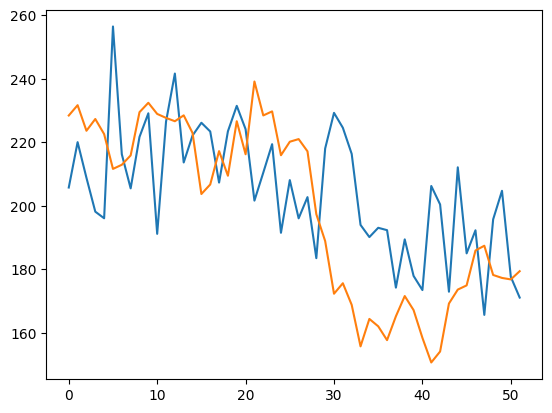

In [148]:
plt.plot(preds[190])
plt.plot(trues[190])

In [130]:
true_df = pd.DataFrame(true)
pred_df = pd.DataFrame(pred)

ValueError: Must pass 2-d input. shape=(191, 1, 52)